# Word Segmentation on ZeroSpeech'17 French

Copyright (c) 2021 Herman Kamper, MIT License

Train a segmental autoencoding recurrent neural network (segmental AE-RNN) and perform word segmentation on encoded ZeroSpeech'17 French.

## Preliminaries

In [1]:
from datetime import datetime
from pathlib import Path
from scipy.stats import gamma
from sklearn import cluster
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn as nn

sys.path.append("..")

from seg_aernn import datasets, models, viterbi
from utils import eval_segmentation

## Utility functions

In [2]:
def get_segmented_sentence(ids, boundaries):
    output = ""
    cur_word = []
    for i_symbol, boundary in enumerate(boundaries):
        cur_word.append(id_to_symbol[ids[i_symbol]])
        if boundary:
            output += "_".join(cur_word)
            output += " "
            cur_word = []
    return output.strip()

In [3]:
# Duration penalty functions

"""
# Histogram
histogram = np.array([
    0, 1.66322800e-01, 2.35838129e-01, 2.10609187e-01,
    1.48025482e-01, 9.42918160e-02, 5.84211098e-02, 3.64679480e-02,
    2.18264741e-02, 1.25420784e-02, 7.18500018e-03, 4.27118399e-03,
    1.73743077e-03, 1.19448366e-03, 7.42027726e-04, 2.89571796e-04,
    2.35277084e-04, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001
    ])  # to-do: check this
histogram = histogram/np.sum(histogram)
def neg_log_hist(dur):
    return -np.log(0 if dur >= len(histogram) else histogram[dur])

# Cached Gamma
# shape, loc, scale = (2.3, 0, 1.3)  # VQ-VAE
shape, loc, scale = (2.6, 0, 1.8)    # CPC-big
# shape, loc, scale = (2.5, 0, 1.5)    # CPC-big (Gamma)
gamma_cache = []
for dur in range(200):
    gamma_cache.append(gamma.pdf(dur, shape, loc, scale))
gamma_cache = np.array(gamma_cache)/np.sum(gamma_cache)
def neg_log_gamma(dur):
    if dur < 200:
        return -np.log(gamma_cache[dur])
    else:
        return -np.log(0)
"""
    
# Chorowski
def neg_chorowski(dur):
    return -(dur - 1)

## Data

In [5]:
# Dataset
vq_model = "cpc_big"
# vq_model = "xlsr"
dataset = "zs2017_fr"
split = "train"
seg_tag = "phoneseg_dp_penalized"
# seg_tag = "phoneseg_dp_penalized_tune"

# Paths
seg_dir = (
    Path("../../vqwordseg/exp")/vq_model/dataset/split/seg_tag/"intervals"
    )
# word_ref_dir = Path("../../vqwordseg/data")/dataset/"word_intervals"

In [6]:
# Read phone segmentation
phoneseg_interval_dict = {}
print("Reading: {}".format(seg_dir))
phoneseg_interval_dict = eval_segmentation.get_intervals_from_dir(seg_dir)
utterances = phoneseg_interval_dict.keys()

  0%|          | 0/47287 [00:00<?, ?it/s]

Reading: ../../vqwordseg/exp/xlsr/zs2017_fr/train/phoneseg_dp_penalized/intervals


100%|██████████| 47287/47287 [00:03<00:00, 13895.28it/s]


In [7]:
prepared_text = []
# n_max_sentence_length = 800
for utt_key in tqdm(utterances):
    prepared_text.append(
        "_".join([i[2] for i in phoneseg_interval_dict[utt_key]])
#         "_".join([i[2] for i in phoneseg_interval_dict[utt_key]][:n_max_sentence_length])
        )
    
print(prepared_text[0])

100%|██████████| 47287/47287 [00:00<00:00, 410020.74it/s]

17_26_7_38_23_9_11_49_28_23_36_21_25_30_16_14_16_31_40_6_39_24_35_41_42_4_22_11_20_15_23_38_46_43_19


In [8]:
# Vocabulary
PAD_SYMBOL      = "<pad>"
SOS_SYMBOL      = "<s>"    # start of sentence
EOS_SYMBOL      = "</s>"   # end of sentence
BOUNDARY_SYMBOL = " "      # word boundary
symbols = set()
for sentence in prepared_text:
    for char in sentence.split("_"):
        symbols.add(char)
SYMBOLS = [PAD_SYMBOL, SOS_SYMBOL, EOS_SYMBOL, BOUNDARY_SYMBOL] + (sorted(list(symbols)))
symbol_to_id = {s: i for i, s in enumerate(SYMBOLS)}
id_to_symbol = {i: s for i, s in enumerate(SYMBOLS)}

def text_to_id(text, add_sos_eos=False):
    """
    Convert text to a list of symbol IDs.

    Sentence start and end symbols can be added by setting `add_sos_eos`.
    """
    symbol_ids = []
    for word in text.split(" "):
        for code in word.split("_"):
            symbol_ids.append(symbol_to_id[code])
        symbol_ids.append(symbol_to_id[BOUNDARY_SYMBOL])
    symbol_ids = symbol_ids[:-1]  # remove last space

    if add_sos_eos:
        return [symbol_to_id[SOS_SYMBOL]] + symbol_ids + [symbol_to_id[EOS_SYMBOL]]
    else:
        return symbol_ids

print(text_to_id(prepared_text[0]))
print([id_to_symbol[i] for i in text_to_id(prepared_text[0])])

[13, 23, 51, 36, 20, 53, 7, 48, 25, 20, 34, 18, 22, 28, 12, 10, 12, 29, 39, 50, 37, 21, 33, 40, 41, 38, 19, 7, 17, 11, 20, 36, 45, 42, 15]
['17', '26', '7', '38', '23', '9', '11', '49', '28', '23', '36', '21', '25', '30', '16', '14', '16', '31', '40', '6', '39', '24', '35', '41', '42', '4', '22', '11', '20', '15', '23', '38', '46', '43', '19']


In [9]:
# First three words of training data
word_dataset = datasets.WordDataset(prepared_text, text_to_id)
for i in range(7):
    sample = word_dataset[i]
    print("_".join([id_to_symbol[i] for i in sample.numpy()]))

17_26_7_38_23_9_11_49_28_23_36_21_25_30_16_14_16_31_40_6_39_24_35_41_42_4_22_11_20_15_23_38_46_43_19
17_26_7_18_22_29_13_48_8_33_35_47_35_40_22_45_1_15_43_32_28_38_4_11_49_1_23_9_23_12_25_13_39_24_49_2_32_28_36_47_21_45_2_31_38_11_18_31_9_11_18_30_16_34_42_12_2_31_16_47_16_38_9_11_49_5_2_32_28_38_12_46_14_46_43_14_19
17_26_7_42_37_48_44_9_4_0_24_49_43_28_10_13_24_22_44_33_18_16_14_34_33_18_30_16_47_34_42_0_18_16_47_16
17_14_26_7_1_6_46
17_26_7_15_27_13_18_22_35_36_22_0_8_41_42_0_18_30_16_34_38_9_11_18_16_14_10_34_9_11_44_27_39_37_48_44_9_11_49_20_43_28_41_42_0_37_44_13_33_24_15_27_36_25_16_22_16_47_10_13_18_16_47_31_40_24_44_45_48_45_22_45_46_14_19
17_26_25_36_24_20_28_31_9_37_15_27_13_18_14_16_34_40_49_43_14_31_40_11_49_28_41_42_0_37_22_44_1_45_33_9_46
17_26_35_33_37_48_44_41_9_48_11_15_20_27_13_24_44_41_38_25_30_23_40_38_36_6_18_16_30_47_16_3_43_14_3_19


In [10]:
# Data

cur_val_sentences = prepared_text[-1000:]
cur_train_sentences = prepared_text
# cur_train_sentences = [i for i in prepared_text if len(i.split("_")) <= 50]  # temp

# Random boundaries
np.random.seed(42)
# cur_train_sentences = insert_random_boundaries(cur_train_sentences)
# cur_val_sentences = insert_random_boundaries(cur_val_sentences)

print("No. train sentences:", len(cur_train_sentences))
print("Examples:", cur_train_sentences[:3])
print("Min length: ", min([len(i.split("_")) for i in cur_train_sentences]))
print("Max length: ", max([len(i.split("_")) for i in cur_train_sentences]))
print("Mean length: {:.4f}".format(np.mean([len(i.split("_")) for i in cur_train_sentences])))

No. train sentences: 47287
Examples: ['17_26_7_38_23_9_11_49_28_23_36_21_25_30_16_14_16_31_40_6_39_24_35_41_42_4_22_11_20_15_23_38_46_43_19', '17_26_7_18_22_29_13_48_8_33_35_47_35_40_22_45_1_15_43_32_28_38_4_11_49_1_23_9_23_12_25_13_39_24_49_2_32_28_36_47_21_45_2_31_38_11_18_31_9_11_18_30_16_34_42_12_2_31_16_47_16_38_9_11_49_5_2_32_28_38_12_46_14_46_43_14_19', '17_26_7_42_37_48_44_9_4_0_24_49_43_28_10_13_24_22_44_33_18_16_14_34_33_18_30_16_47_34_42_0_18_16_47_16']
Min length:  1
Max length:  239
Mean length: 39.6244


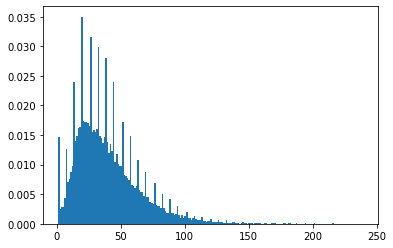

In [11]:
plt.hist([len(i.split("_")) for i in cur_train_sentences], 200, density=True)
# plt.xlim([0, 100])
plt.show()

## Model

In [12]:
# AE-RNN model
n_symbols = len(SYMBOLS)
symbol_embedding_dim = 10  # 25
hidden_dim = 500  # 250  # 500  # 1000  # 200
embedding_dim = 50  # 150  # 300  # 25
teacher_forcing_ratio = 0.5  # 1.0  # 0.5  # 1.0
n_encoder_layers = 1  # 1  # 3  # 10
n_decoder_layers = 1  # 1  # 1
batch_size = 32  # 32*3  # 32
learning_rate = 0.001
input_dropout = 0.0  # 0.0 # 0.5
dropout = 0.0
n_symbols_max = 50  # 25
# n_epochs_max = 5
n_epochs_max = None  # determined from n_max_steps and batch size
n_steps_max = 1500  # 2500  # 1500  # 1000  # None
# n_steps_max = None  # Only use n_epochs_max
bidirectional_encoder = False  # False

encoder = models.Encoder(
    n_symbols=n_symbols,
    symbol_embedding_dim=symbol_embedding_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_encoder_layers,
    dropout=dropout,
    input_dropout=input_dropout,
    bidirectional=bidirectional_encoder
    )
# decoder = models.Decoder1(
#     n_symbols=n_symbols,
#     symbol_embedding_dim=symbol_embedding_dim,
#     hidden_dim=hidden_dim,
#     embedding_dim=embedding_dim,
#     n_layers=n_decoder_layers,
#     sos_id = symbol_to_id[SOS_SYMBOL],
#     teacher_forcing_ratio=teacher_forcing_ratio,
#     dropout=dropout
#     )
decoder = models.Decoder2(
    n_symbols=n_symbols,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_decoder_layers,
    dropout=dropout
    )
model = models.EncoderDecoder(encoder, decoder)

## Pre-training

In [13]:
# Training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Training data
train_dataset = datasets.WordDataset(
    cur_train_sentences, text_to_id, n_symbols_max=n_symbols_max
    )
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Validation data
val_dataset = datasets.WordDataset(cur_val_sentences, text_to_id)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Loss
criterion = nn.NLLLoss(
    reduction="sum", ignore_index=symbol_to_id[PAD_SYMBOL]
    )
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

if n_epochs_max is None:
    steps_per_epoch = np.ceil(len(cur_train_sentences)/batch_size)
    n_epochs_max = int(np.ceil(n_steps_max/steps_per_epoch))

i_step = 0
for i_epoch in range(n_epochs_max):

    # Training
    model.train()
    train_losses = []
    for i_batch, (data, data_lengths) in enumerate(tqdm(train_loader)):
        optimiser.zero_grad()
        data = data.to(device)       
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        loss = criterion(
            decoder_output.contiguous().view(-1, decoder_output.size(-1)),
            data.contiguous().view(-1)
            )
        loss /= len(data_lengths)
        loss.backward()
        optimiser.step()
        train_losses.append(loss.item())
        i_step += 1
        if i_step == n_steps_max and n_steps_max is not None:
            break
    
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for i_batch, (data, data_lengths) in enumerate(val_loader):
            data = data.to(device)            
            encoder_embedding, decoder_output = model(
                data, data_lengths, data, data_lengths
                )

            loss = criterion(
                decoder_output.contiguous().view(-1,
                decoder_output.size(-1)), data.contiguous().view(-1)
                )
            loss /= len(data_lengths)
            val_losses.append(loss.item())
    
    print(
        "Epoch {}, train loss: {:.3f}, val loss: {:.3f}".format(
        i_epoch,
        np.mean(train_losses),
        np.mean(val_losses))
        )
    sys.stdout.flush()

    if i_step == n_steps_max and n_steps_max is not None:
        break

100%|██████████| 1478/1478 [00:45<00:00, 32.40it/s]


Epoch 0, train loss: 110.240, val loss: 122.526


  1%|▏         | 21/1478 [00:00<00:46, 31.33it/s]


Epoch 1, train loss: 102.575, val loss: 124.880


In [14]:
# Examples without segmentation

# Apply to validation data
model.eval()
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(val_loader):
        data = data.to(device)
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )
        
        y, log_probs = model.decoder.greedy_decode(
            encoder_embedding,
            max_length=25,
            )
        x = data.cpu().numpy()
        
        for i_input in range(y.shape[0]):
            # Only print up to EOS symbol
            input_symbols = []
            for i in x[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                input_symbols.append(id_to_symbol[i])
            output_symbols = []
            for i in y[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                output_symbols.append(id_to_symbol[i])

            print("Input: ", "_".join(input_symbols))
            print("Output:", "_".join(output_symbols))
            print()
            
            if i_input == 10:
                break
        
        break

Input:  17_26_40_8_13_6_37_1_27_33_8_42_0_49_22_2_14_28_31_8_45_22_45_46_47_19
Output: 17_26_7_37_37_35_35_35_13_13_39_39_49_49_2_2_28_28_10_10_45_45_45_46_46

Input:  26_9_11_2_31_38_22_23_40_18_16_14_31_9_11_48_27_41_42_0_37_41_42_0_49_22_2_41_42_25_5_25_21_1_45_47_45_46_19
Output: 26_42_18_28_28_38_38_11_11_11_38_38_38_38_38_38_38_38_38_38_38_38_38_38_38

Input:  17_26_7_36_42_25_20_2_14_31_40_33_37_27_39_18_16_1_34_39_37_22_44_12_22_12_18_5_3_14_3_19
Output: 17_26_7_7_33_49_20_2_28_31_36_0_37_44_44_44_33_33_33_33_33_33_16_22_22

Input:  17_26_38_37_1_44_33_37_13_24_20_14_28_34_36_21_46_19
Output: 17_26_42_37_27_27_27_39_49_20_14_14_28_10_13_45_46_46_19_19_19_19_19_19_19

Input:  17_26_31_40_6_27_39_24_15_27_39_6_2_28_36_0_49_20_43_28_34_6_5_35_15_27_33_49_20_2_28_40_23_33_44_48_13_1_33_23_5_23_33_15_22_27_39_24_18_5_16_14_16_10_6_49_2_14_28_43_28_10_13_2_28_6_15_27_39_24_49_28_16_2_31_36_24_18_1_16_10_33_9_11_29_1_29_34_42_4_1_25_11_48_44_9_11_2_43_3_19
Output: 17_26_7_8_37_35_33_3

## Segmentation

In [15]:
# Utterances for evaluation
n_eval_utterances = len(prepared_text)  # 1000  # 10000  # 1000
# eval_sentences = prepared_text[-n_eval_utterances:]  # val sentences
# eval_utterances = list(utterances)[-n_eval_utterances:]
eval_sentences = prepared_text[:n_eval_utterances]
eval_utterances = list(utterances)[:n_eval_utterances]

In [16]:
# Embed segments

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Data
sentences = eval_sentences
# sentences = cur_val_sentences
interval_dataset = datasets.SentenceIntervalDataset(
    sentences,
    text_to_id,
    join_char="_"
    )
segment_loader = DataLoader(
    interval_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=datasets.pad_collate,
    drop_last=False
    )

# Apply model to data
model.decoder.teacher_forcing_ratio = 1.0
model.eval()
rnn_losses = []
lengths = []
eos = []
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(tqdm(segment_loader)):
        data = data.to(device)

        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        for i_item in range(data.shape[0]):
            item_loss = criterion(
                decoder_output[i_item].contiguous().view(-1,
                decoder_output[i_item].size(-1)),
                data[i_item].contiguous().view(-1)
                )
            rnn_losses.append(item_loss.cpu().numpy())
            lengths.append(data_lengths[i_item])

100%|██████████| 727516/727516 [1:02:40<00:00, 193.44it/s]


In [21]:
# Segment

dur_weight = 3.0  # 3.0

i_item = 0
losses = []
cur_segmented_sentences = []
for i_sentence, intervals in enumerate(tqdm(interval_dataset.intervals)):
    
    # Costs for segment intervals
    costs = np.inf*np.ones(len(intervals))
    i_eos = intervals[-1][-1]
    for i_seg, interval in enumerate(intervals):
        if interval is None:
            continue
        i_start, i_end = interval
        dur = i_end - i_start
        assert dur == lengths[i_item]
        eos = (i_end == i_eos)  # end-of-sequence
        
        # Chorowski
        costs[i_seg] = (
            rnn_losses[i_item]
            + dur_weight*neg_chorowski(dur)
            )
        
#         # Gamma
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + dur_weight*neg_log_gamma(dur)
#             + np.log(np.sum(gamma_cache**dur_weight))
#             )
        
#         # Poisson
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + neg_log_poisson(dur)
#             )

#         # Histogram
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + dur_weight*(neg_log_hist(dur))
#             + np.log(np.sum(histogram**dur_weight))
#             )
    
#         # Sequence boundary
#         alpha = 0.3  # 0.3  # 0.9
#         if eos:
#             costs[i_seg] += -np.log(alpha)
#         else:
#             costs[i_seg] += -np.log(1 - alpha)
# #             K = 5000
# #             costs[i_seg] += -np.log((1 - alpha)/K)

        # Temp
#         if dur > 10 or dur <= 1:
#             costs[i_seg] = +np.inf
        i_item += 1
    
    # Viterbi segmentation
    n_frames = len(interval_dataset.sentences[i_sentence])
    summed_cost, boundaries = viterbi.custom_viterbi(costs, n_frames)
    losses.append(summed_cost)
    
    reference_sentence = sentences[i_sentence]
    segmented_sentence = get_segmented_sentence(
            interval_dataset.sentences[i_sentence],
            boundaries
            )
    cur_segmented_sentences.append(segmented_sentence)
#     # Print examples of the first few sentences
#     if i_sentence < 10:
#         print(reference_sentence)
#         print(segmented_sentence)
#         print()

print("NLL: {:.4f}".format(np.sum(losses)))

100%|██████████| 47287/47287 [00:45<00:00, 1034.56it/s]

NLL: -435883.2168


## Evaluation

In [22]:
print(f"{eval_utterances[0]}:")
print(cur_segmented_sentences[0])

# # To evaluate gold segmentation:
# cur_segmented_sentences = prepared_text_gold[:n_eval_utterances]
# print(cur_segmented_sentences[0])

M05_R_540774-540911:
17_26_7_38_23_9_11_49_28_23 36_21_25 30_16_14_16_31_40_6 39_24_35 41_42_4_22_11 20_15_23_38_46_43_19


In [23]:
# Convert segmentation to intervals
segmentation_interval_dict = {}
for i_utt, utt_key in tqdm(enumerate(eval_utterances)):
    words_segmented = cur_segmented_sentences[i_utt].split(" ")
    word_start = 0
    word_label = ""
    i_word = 0
    segmentation_interval_dict[utt_key] = []
    for (phone_start, phone_end,
            phone_label) in phoneseg_interval_dict[utt_key]:
        word_label += phone_label + "_"
        if words_segmented[i_word] == word_label[:-1]:
            segmentation_interval_dict[utt_key].append((
                word_start, phone_end, word_label[:-1]
                ))
            word_label = ""
            word_start = phone_end
            i_word += 1

#     if i_utt < 10:
#         print(segmentation_interval_dict[utt_key])
#         print(word_ref_interval_dict[utt_key])
#         print()        

47287it [00:00, 67439.96it/s]


In [24]:
# Write intervals to a directory
output_tag = "wordseg_segaernn_{}".format(seg_tag.replace("phoneseg_", ""))
output_dir = (
    Path("../../vqwordseg/exp")/vq_model/dataset/split/output_tag/"intervals"
    )
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Writing to: {output_dir}")
for utt_key in tqdm(segmentation_interval_dict):
    with open((output_dir/utt_key).with_suffix(".txt"), "w") as f:
        for (i_segment, (start, end, label)) in enumerate(segmentation_interval_dict[utt_key]):
            f.write(f"{start:d} {end:d} {label}_\n")

  2%|▏         | 1133/47287 [00:00<00:04, 11329.04it/s]

Writing to: ../../vqwordseg/exp/xlsr/zs2017_fr/train/wordseg_segaernn_dp_penalized/intervals


100%|██████████| 47287/47287 [00:05<00:00, 9348.41it/s] 
